# Character Segmentation
****

## Importing Dependencies

In [1]:
import cv2 
import os
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

from skimage.filters import sobel
from skimage.segmentation import watershed

## Load Handwritten Document Image

### Preprocessing Functions

In [2]:
def preprocessing_image(img, blur_radius=50, plot=0, plot_blur=0, plot_segmentation=0, otsu=0):
    sharpen_kernel = np.array([[-1, -1, -1],
                               [-1, 10, -1],
                               [-1, -1, -1]])
    sharpen = cv2.filter2D(img, -1, sharpen_kernel)
    gray = cv2.cvtColor(sharpen, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (9, 9), blur_radius)
    
    if otsu:
        _, threshold = cv2.threshold(blur, 80, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    else:
        _, threshold = cv2.threshold(blur, 80, 255, cv2.THRESH_BINARY_INV)
    elevation_map = sobel(threshold)
    markers = np.zeros_like(threshold)
    markers[threshold < 30] = 1
    markers[threshold > 150] = 2
    segmentation_ = watershed(elevation_map, markers)
    segmentation_noramlized = cv2.normalize(src = segmentation_, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    titles = ['GRAY', 'BLUR', 'THRESHOLD', 'ELEVATION MAP', 'SEGMENTATION']
    images = [gray, blur, threshold, elevation_map, segmentation_]
    if plot:
        plt.figure(figsize=(20,20))
        for i in np.arange(len(images)):
            plt.subplot(3, 3, i+1)
            plt.imshow(images[i], 'gray')
            plt.title(titles[i])
        plt.show()
        
    if plot_blur:
        plt.imshow(blur, cmap='gray')
        plt.show()

    if plot_segmentation:
        plt.imshow(segmentation_noramlized, cmap='gray')
        plt.show()
        
    print('Returned segmented image.')
    return segmentation_noramlized

In [3]:
def sentence_segmentation(img, height=3, width=85, plot=0):
    kernel=np.ones((height, width),np.uint8)
    dilated=cv2.dilate(img, kernel, iterations=1)
    if plot:
        plt.imshow(dilated)
        plt.show()
    print('Returned sentence_segmented imgage.')
    return dilated

In [4]:
def bounding(img, epsilon=5, x=0, y=0):
    contours, hierearchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours_poly = [None] * len(contours)
    
    boundRect = []
    for i, c in enumerate(contours):
        if hierearchy[0][i][3] == -1:
            contours_poly[i] = cv2.approxPolyDP(c, epsilon, True)
            boundRect.append(cv2.boundingRect(contours_poly[i]))
    if x:
            boundRect = sorted(boundRect, key=lambda a: a[0], reverse=False)
    if y:
        boundRect = sorted(boundRect, key=lambda a: a[1], reverse=False)

    print('Returned list of bounding rectangles.')
    return boundRect

In [5]:
def segmented_list(boundRect, const_ht=0):
    segmented_list = []
    for i in range(len(boundRect)):
        dimension_offset = 5
        position_offset = 2
        x, y, w, h = boundRect[i]
        h = h + dimension_offset
        w = w + dimension_offset
        x = x - position_offset
        y = y - position_offset
        
        if const_ht:
            y=boundRect[i][1]
            h=boundRect[i][-1]
            
        croppedImg = img[y:y+h, x:x+w]
        segmented_list.append(croppedImg)
        
    print('Returned list of segmented images.')
    return segmented_list

In [6]:
def plot_bounds(img, bound_list):
    img_copy = img.copy()
    for i in range(len(bound_list)):
        color = (255, 0, 0)
        cv2.rectangle(img_copy, 
                     (int(bound_list[i][0]), int(bound_list[i][1])),
                     (int(bound_list[i][0] + bound_list[i][2]), 
                      int(bound_list[i][1] +bound_list[i][3])),
                      color, 1)
    plt.imshow(img_copy)
    plt.title('Segmentated Bounding Box')
    plt.axis('off')
    plt.show()

## Driver Code

In [15]:
img = cv2.imread('dataset/Handwrttingp2.jpg')
img = cv2.resize(img, (img.shape[0]*2, img.shape[1]*2))
img_copy = img.copy()

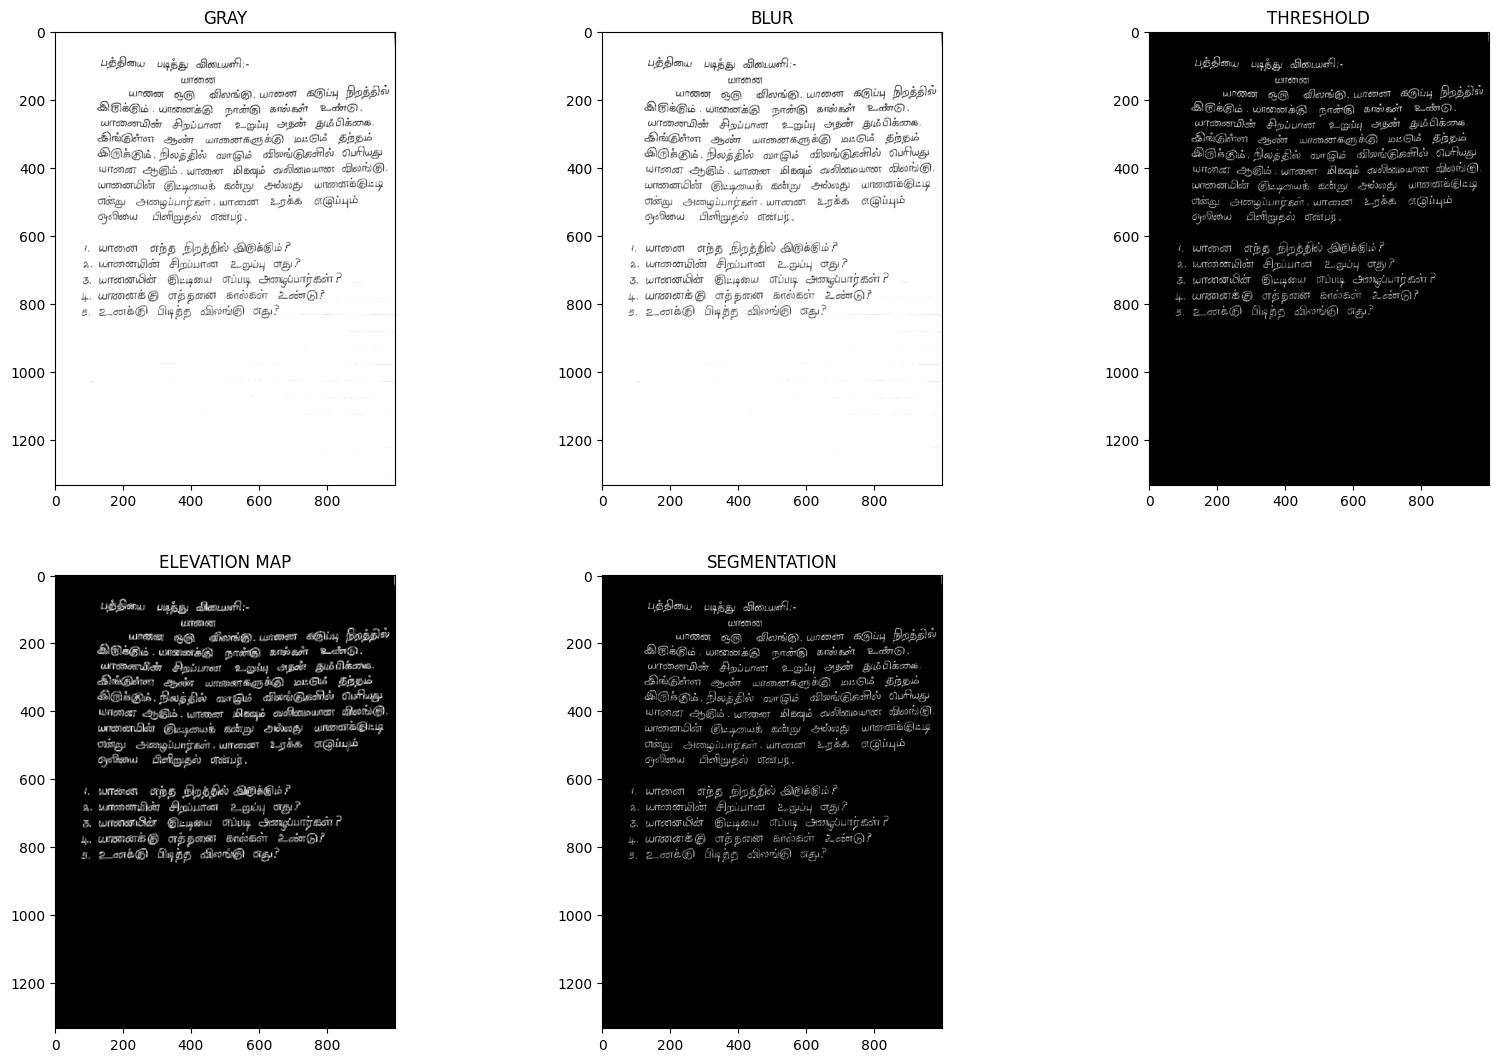

Returned segmented image.


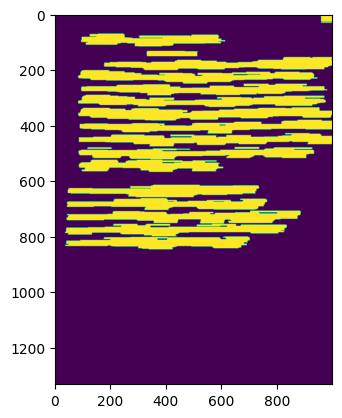

Returned sentence_segmented imgage.
Returned list of bounding rectangles.


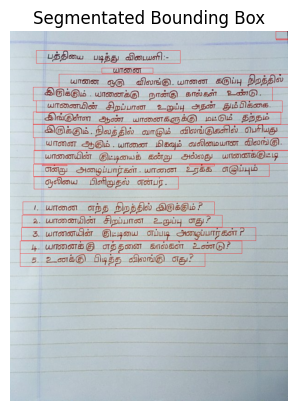

Returned list of segmented images.


In [8]:
doc_segmented_img = preprocessing_image(img, plot=1, blur_radius=.01, otsu=0)
sentence_segmented_img = sentence_segmentation(doc_segmented_img, plot=1) 
sentence_bound_list = bounding(sentence_segmented_img, y=1)
plot_bounds(img, sentence_bound_list)
cropped_list = segmented_list(sentence_bound_list)

In [9]:
for idx, item in enumerate(cropped_list):
    if len(item) == 0:
       cropped_list.remove(cropped_list[idx])

ValueError: num must be an integer with 1 <= num <= 9, not 10

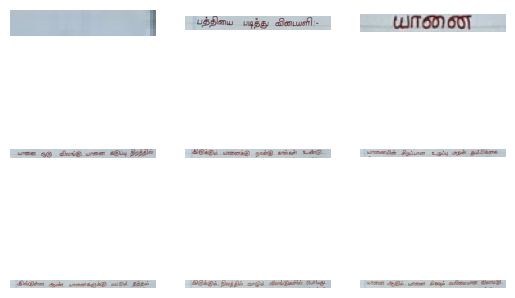

In [10]:
plt.figure()
for i in np.arange(len(cropped_list)):
    plt.subplot(3, 3, i+1)
    plt.imshow(cropped_list[i], 'gray')
    plt.axis('off')
plt.show()

In [18]:
len(cropped_list)

19

## Word Segmentation

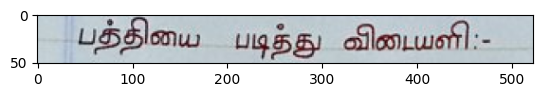

In [19]:
img = cropped_list[1]
plt.imshow(img)

Returned segmented image.
Returned sentence_segmented imgage.
Returned list of bounding rectangles.


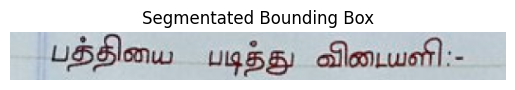

Returned list of segmented images.


In [20]:
doc_segmented_img = preprocessing_image(img)
sentence_segmented_img = sentence_segmentation(doc_segmented_img) 
sentence_bound_list = bounding(sentence_segmented_img, x=1)
plot_bounds(img, sentence_bound_list)
cropped_list = segmented_list(sentence_bound_list)

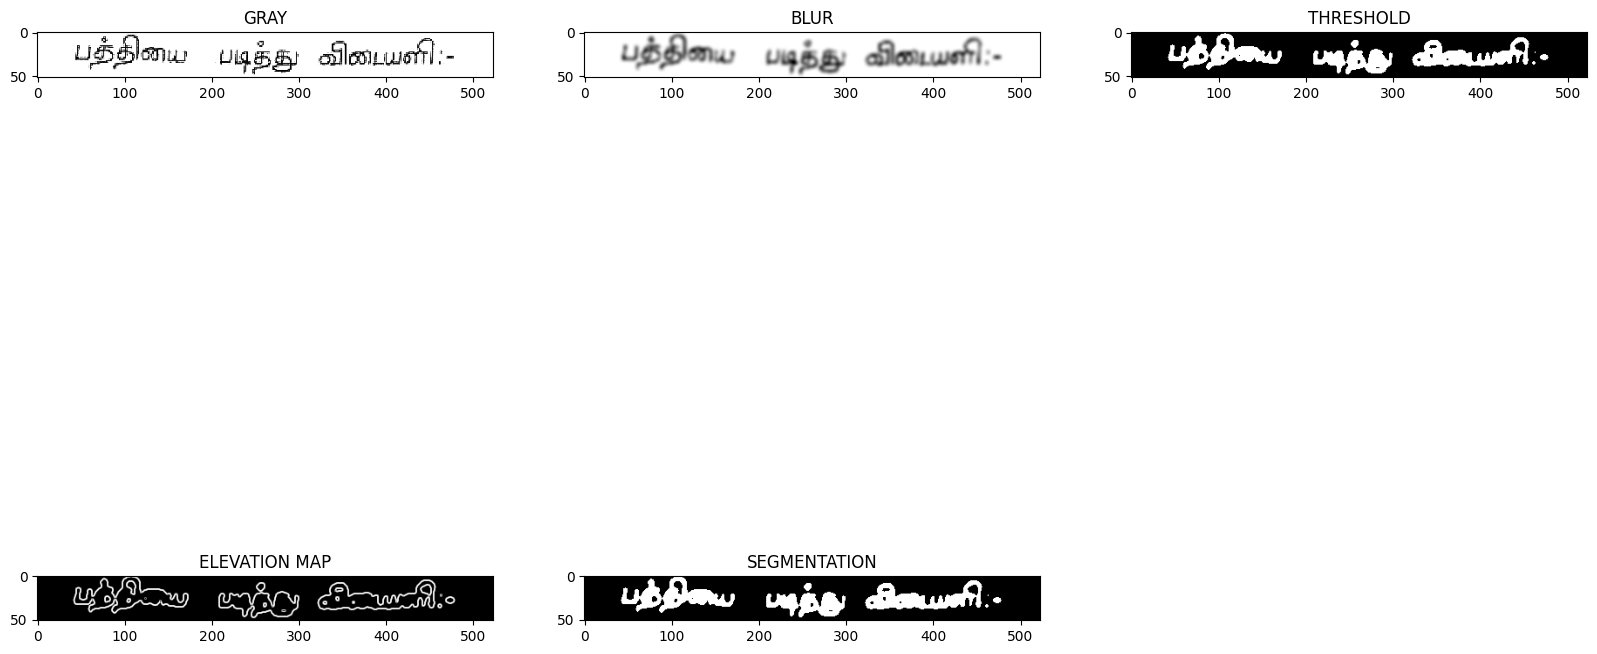

Returned segmented image.
Returned list of bounding rectangles.


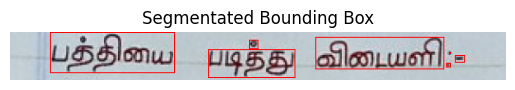

Returned list of segmented images.


In [21]:
word_seg_img = preprocessing_image(img, 2, plot=1, otsu=1)
char_bound_list = bounding(word_seg_img, 1, x=1)
plot_bounds(img, char_bound_list)
char_list = segmented_list(char_bound_list, const_ht=1)

char_list.remove(char_list[0])

In [22]:
for idx, item in enumerate(char_list):
    if len(item) == 0:
       cropped_list.remove(char_list[idx])

In [23]:
char_bound_list[0]

(42, 1, 131, 42)

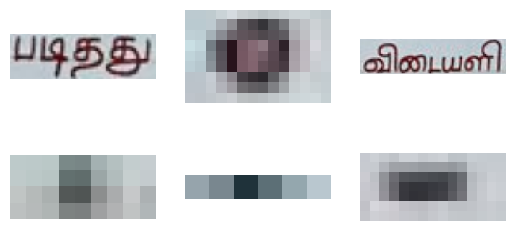

In [24]:
plt.figure()
for i in np.arange(len(char_list)):
    plt.subplot(3, 3, i+1)
    plt.imshow(char_list[i], 'gray')
    plt.axis('off')
plt.show()

## Character Segmentation

(209, 19, 91, 29)


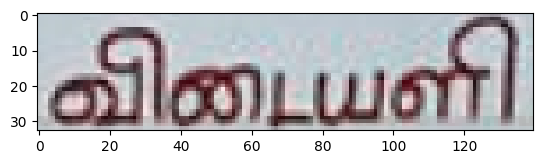

In [25]:
img = char_list[2]
print(char_bound_list[1])
plt.imshow(img)

Returned segmented image.
Returned list of bounding rectangles.


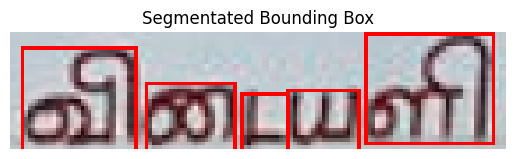

Returned list of segmented images.


In [26]:
img = char_list[2]

char_img = preprocessing_image(img, blur_radius=0.8, otsu=1)
th = cv2.adaptiveThreshold(char_img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,3,0)
char_bound_list = bounding(th, 1, x=1)
plot_bounds(img, char_bound_list)

char_segmented_list = segmented_list(char_bound_list, 1)

In [27]:
temp = 0
for idx, bound in enumerate(char_bound_list):
    x,y,w,h = bound
    x_bound = x+w
    y_bound = y+h
    # print(x_bound)
    if x_bound < temp:
        prev_bound = np.array(char_bound_list[idx-1])
        prev_bound[1] = bound[1]
        prev_bound[-1] = prev_bound[-1] + y_bound + bound[-1] + 5
        char_bound_list[idx-1] = tuple(prev_bound)
        char_bound_list.remove(bound)
    else: 
        temp = x_bound

char_bound_list

[(3, 4, 32, 29),
 (38, 14, 25, 19),
 (65, 17, 13, 16),
 (78, 16, 20, 17),
 (100, 0, 36, 31)]

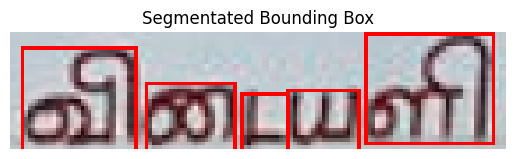

In [28]:
plot_bounds(img, char_bound_list)

In [29]:
char_segmented_list = segmented_list(char_bound_list, 1)

Returned list of segmented images.


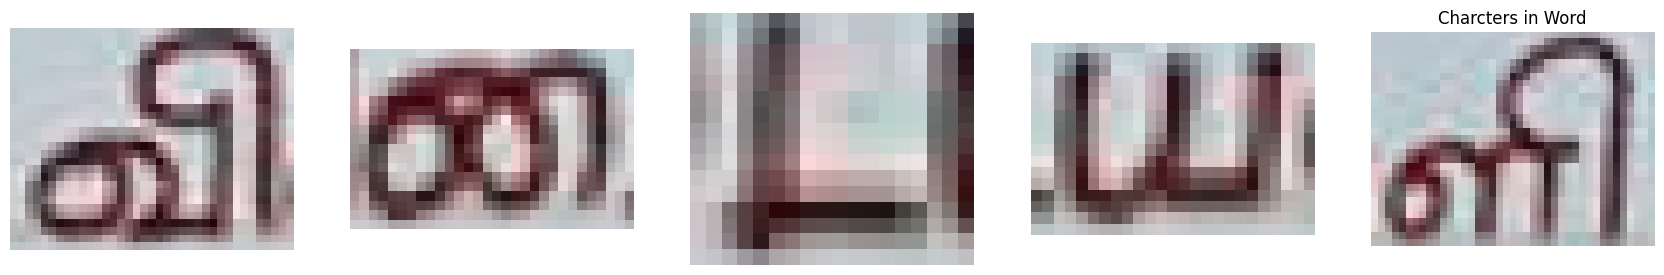

In [30]:
plt.figure(figsize=(30,30))
for i in np.arange(len(char_segmented_list)):
    try:
        plt.subplot(7, 7, i+1)
        plt.imshow(char_segmented_list[i])
        plt.axis('off')
    except:
        pass
plt.title('Charcters in Word')
plt.show()

## Exporting Characters

In [31]:
char_path = 'characters/'

In [32]:
try:
    if os.path.exists(char_path):
        img_list = os.listdir(char_path)[1:]
        for img in img_list:
            img=os.path.join(char_path, img)
            os.remove(img)
    
    os.rmdir('characters')
    os.mkdir('characters')
    
except:
  print('Folder already exists')


Folder already exists


In [33]:
i=0
for img in char_segmented_list:
    i += 1
    plt.imsave(f'characters/char{i}.jpeg', img)
print('Charcters saved successfully.')

Charcters saved successfully.
